In [67]:
import pandas as pd
import pyodbc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

Dataframe setup and cleaning

In [68]:
# Database connection
server = 'DESKTOP-B864QQK\SQLEXPRESS'
database = 'Capstone'
username = 'TestUser'
password = '5555'

conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};Trusted_Connection=Yes'
conn = pyodbc.connect(conn_str)

# Load the data
query = "SELECT * FROM dbo.SirioLibanesICUPrediction"
df = pd.read_sql(query, conn)
print("Initial data sample:")
(df.head(10))

Initial data sample:


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,,,,,,,,,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,,,,,-1.0,-1.0,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.2380952380952372,-0.8181818181818181,-0.3899665551839465,0.4075579938177061,-0.2304616503089786,0.09677419354838701,-0.2422815279958128,-0.8144329896907216,ABOVE_12,1
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.8809523809523809,-1.0,-0.906832298136646,-0.8311322797142239,-0.9409669211195929,-0.8172043010752689,-0.8825742831192422,-1.0,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.1428571428571423,-0.797979797979798,0.3156899810964082,0.2003590817766001,-0.2395150426582848,0.6451612903225805,0.1397087760724121,-0.8023169305983633,ABOVE_12,1


In [69]:
# Step 1: Handle missing values by dropping columns with too many missing values
threshold = 0.7  # Allow up to 30% missing data per column
df_cleaned = df.dropna(thresh=int((1 - threshold) * len(df)), axis=1)

# Step 2: Impute missing values based on data type
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
    else:
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
print(f"Shape of the cleaned dataset: {df_cleaned.shape}")

# Step 3: Rename columns for better readability
df_cleaned = df_cleaned.rename(columns={
    'AGE_ABOVE65': 'Age_Above_65',
    'AGE_PERCENTIL': 'Age_Percentile',
    'GENDER': 'Gender',
    'DISEASE GROUPING 1': 'Disease_Group_1',
    'DISEASE GROUPING 2': 'Disease_Group_2',
    'DISEASE GROUPING 3': 'Disease_Group_3',
    'DISEASE GROUPING 4': 'Disease_Group_4',
    'DISEASE GROUPING 5': 'Disease_Group_5',
    'DISEASE GROUPING 6': 'Disease_Group_6',
    'ICU': 'ICU_Status',
    'ALBUMIN_MEDIAN': 'Albumin_Median',
    'ALBUMIN_MEAN': 'Albumin_Mean',
    'ALBUMIN_MIN': 'Albumin_Min',
    'ALBUMIN_MAX': 'Albumin_Max',
    'ALBUMIN_DIFF': 'Albumin_Diff',
    'BLOODPRESSURE_DIASTOLIC_DIFF_REL': 'BloodPressure_Diastolic_Diff_Relative',
    'BLOODPRESSURE_SISTOLIC_DIFF_REL': 'BloodPressure_Systolic_Diff_Relative',
    'HEART_RATE_DIFF_REL': 'Heart_Rate_Diff_Relative',
    'RESPIRATORY_RATE_DIFF_REL': 'Respiratory_Rate_Diff_Relative',
    'TEMPERATURE_DIFF_REL': 'Temperature_Diff_Relative',
    'OXYGEN_SATURATION_DIFF_REL': 'Oxygen_Saturation_Diff_Relative',
    'RESPIRATORY_RATE_DIFF': 'Respiratory_Rate_Diff',
})
print("Renamed columns:")
(df_cleaned.head(10))

Shape of the cleaned dataset: (1925, 231)
Renamed columns:


,PATIENT_VISIT_IDENTIFIER,Age_Above_65,Age_Percentile,Gender,Disease_Group_1,Disease_Group_2,Disease_Group_3,Disease_Group_4,Disease_Group_5,Disease_Group_6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BloodPressure_Diastolic_Diff_Relative,BloodPressure_Systolic_Diff_Relative,Heart_Rate_Diff_Relative,Respiratory_Rate_Diff_Relative,Temperature_Diff_Relative,Oxygen_Saturation_Diff_Relative,WINDOW,ICU_Status
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,,,,,,,,,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,,,,,-1.0,-1.0,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.2380952380952372,-0.8181818181818181,-0.3899665551839465,0.4075579938177061,-0.2304616503089786,0.09677419354838701,-0.2422815279958128,-0.8144329896907216,ABOVE_12,1
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.8809523809523809,-1.0,-0.906832298136646,-0.8311322797142239,-0.9409669211195929,-0.8172043010752689,-0.8825742831192422,-1.0,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.1428571428571423,-0.797979797979798,0.3156899810964082,0.2003590817766001,-0.2395150426582848,0.6451612903225805,0.1397087760724121,-0.8023169305983633,ABOVE_12,1


In [70]:
# Step 4: Convert relevant columns to numeric
columns_to_convert = [
    'Respiratory_Rate_Diff',
    'BloodPressure_Diastolic_Diff_Relative',
    'Heart_Rate_Diff_Relative',
    'BloodPressure_Systolic_Diff_Relative'
]
for col in columns_to_convert:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
print("Column data types after conversion:")
(df_cleaned[columns_to_convert].dtypes)

Column data types after conversion:


Respiratory_Rate_Diff                    float64
BloodPressure_Diastolic_Diff_Relative    float64
Heart_Rate_Diff_Relative                 float64
BloodPressure_Systolic_Diff_Relative     float64
dtype: object

In [71]:
# Step 5: Outlier detection and removal
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
outliers = {}
for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
for col, outliers_data in outliers.items():
    print(f'Outliers in {col}:')
    print(outliers_data.head())  # Display first few outliers for each column
(f"Shape of the dataset after outlier handling: {df_cleaned.shape}")

Outliers in Respiratory_Rate_Diff:
   PATIENT_VISIT_IDENTIFIER Age_Above_65 Age_Percentile Gender  \
4                         0            1           60th      0   
9                         1            1           90th      1   
59                       11            1           80th      0   
74                       14            1           60th      1   
79                       15            0           50th      0   

   Disease_Group_1 Disease_Group_2 Disease_Group_3 Disease_Group_4  \
4              0.0             0.0             0.0             0.0   
9              0.0             0.0             0.0             0.0   
59             0.0             0.0             0.0             0.0   
74             0.0             0.0             0.0             0.0   
79             0.0             0.0             0.0             0.0   

   Disease_Group_5 Disease_Group_6  ...     TEMPERATURE_DIFF  \
4              1.0             1.0  ...  -0.2380952380952372   
9              1.0 

'Shape of the dataset after outlier handling: (786, 231)'

In [72]:
# Step 6: Scaling numeric columns
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df_cleaned[numeric_columns] = scaler.fit_transform(df_cleaned[numeric_columns])
print("First 10 rows after scaling:")
(df_cleaned.head(10))

First 10 rows after scaling:


,PATIENT_VISIT_IDENTIFIER,Age_Above_65,Age_Percentile,Gender,Disease_Group_1,Disease_Group_2,Disease_Group_3,Disease_Group_4,Disease_Group_5,Disease_Group_6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BloodPressure_Diastolic_Diff_Relative,BloodPressure_Systolic_Diff_Relative,Heart_Rate_Diff_Relative,Respiratory_Rate_Diff_Relative,Temperature_Diff_Relative,Oxygen_Saturation_Diff_Relative,WINDOW,ICU_Status
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-0.488418,-0.499288,-0.515765,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-0.488418,-0.499288,-0.515765,-1.0,-1.0,-1.0,2-4,0
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-0.488418,-0.499288,-0.515765,-1.0,-1.0,-1.0,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-0.488418,-0.499288,-0.515765,-1.0,-1.0,-1.0,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-0.488418,-0.499288,-0.515765,-1.0,-1.0,-1.0,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.8809523809523809,-1.0,0.460089,0.812085,0.384769,-0.8172043010752689,-0.8825742831192422,-1.0,6-12,1
12,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,,-0.9595959595959596,4.443818,4.538094,3.343668,-0.7562724014336918,,-0.9612621055920025,4-6,0
17,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-0.488418,-0.499288,-0.515765,-1.0,-1.0,-1.0,4-6,0
18,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-0.488418,-0.499288,-0.515765,-1.0,-1.0,-1.0,6-12,0
22,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.9523809523809517,-0.9797979797979798,-0.488418,0.404102,0.143163,-0.8709677419354839,-0.9535361314337049,-0.9803330689928628,4-6,0


In [73]:
# Step 7: Machine learning pipeline preparation and testing
categorical_cols = [
    'Age_Percentile', 'Gender', 'Disease_Group_1', 'Disease_Group_2',
    'Disease_Group_3', 'Disease_Group_4', 'Disease_Group_5', 'Disease_Group_6'
]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), df_cleaned.drop(columns=categorical_cols).select_dtypes(include=[np.number]).columns)
    ])
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned.drop('ICU_Status', axis=1),
    df_cleaned['ICU_Status'],
    test_size=0.2,
    random_state=42
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6835


In [74]:
# Final check for duplicates
duplicate_rows = df_cleaned[df_cleaned.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
if duplicate_rows.shape[0] > 0:
    print(duplicate_rows.head())
else:
    print("No duplicates found.")

Number of duplicate rows: 0
No duplicates found.


EDA visuals

Distribution of ICU Admissions
    Description: This bar chart displays the distribution of patients who were admitted to the ICU versus those who were not. It reveals that a higher number of patients (551) did not require 
    ICU admission compared to those who did (235), indicating that the majority of patients in the dataset did not experience severe enough conditions to necessitate intensive care.

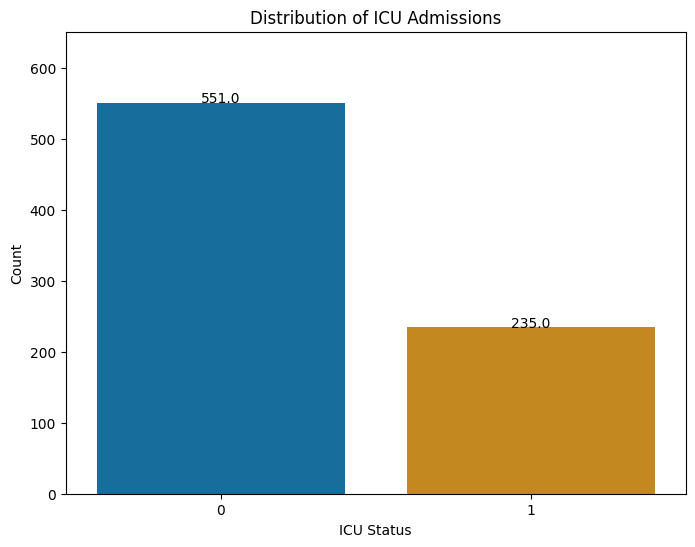

In [75]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_cleaned, x='ICU_Status', palette='colorblind')
plt.title('Distribution of ICU Admissions')
plt.xlabel('ICU Status')
plt.ylabel('Count')
plt.ylim(0, max(df_cleaned['ICU_Status'].value_counts()) + 100)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.show()

Relative Differences in Vital Signs
    Description: This set of density plots illustrates the relative differences in key vital signs (Blood Pressure Diastolic, Heart Rate, Blood Pressure Systolic, and Temperature) across the patient population. The concentration of values around the lower end suggests that the majority of patients had relatively stable vital signs, but with some variations that could correlate with ICU admission status.

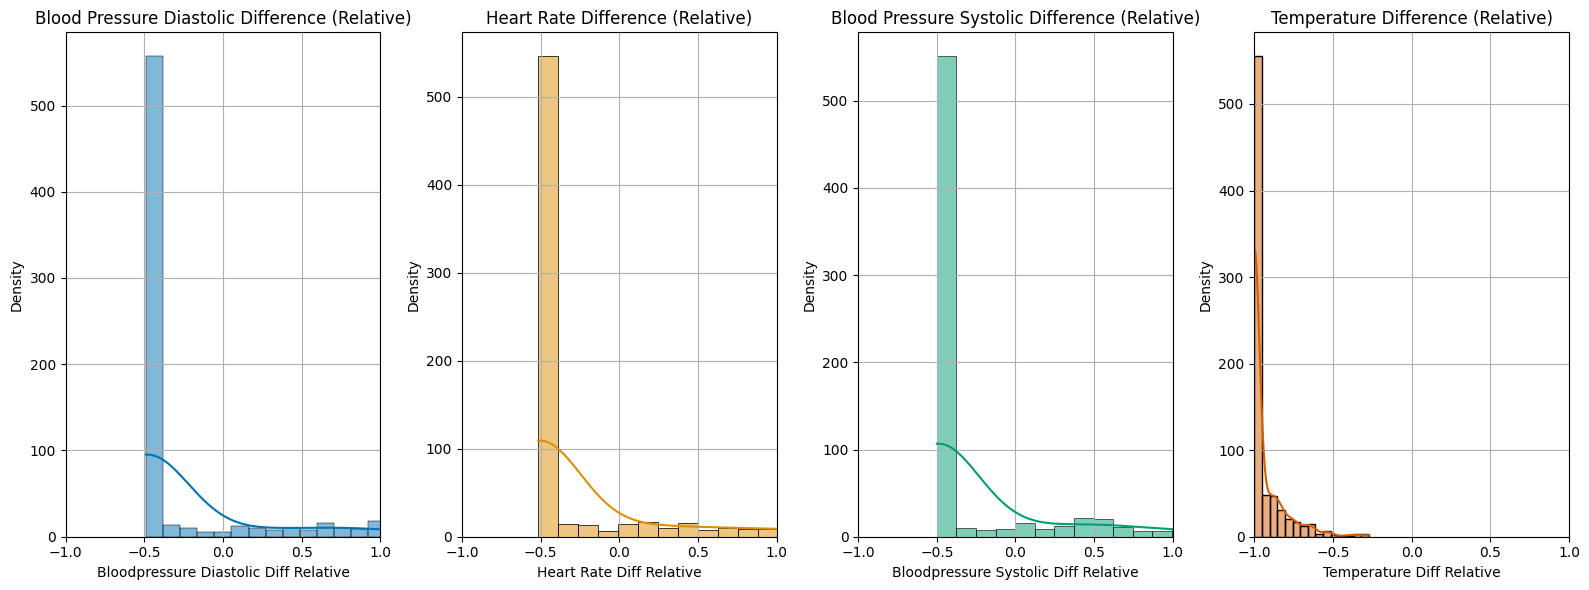

In [76]:
key_features = [
    ('BloodPressure_Diastolic_Diff_Relative', 'Blood Pressure Diastolic Difference (Relative)'),
    ('Heart_Rate_Diff_Relative', 'Heart Rate Difference (Relative)'),
    ('BloodPressure_Systolic_Diff_Relative', 'Blood Pressure Systolic Difference (Relative)'),
    ('Temperature_Diff_Relative', 'Temperature Difference (Relative)')
]
for feature, _ in key_features:
    df_cleaned[feature] = pd.to_numeric(df_cleaned[feature], errors='coerce')
fig, axes = plt.subplots(1, len(key_features), figsize=(16, 6))
for i, (feature, title) in enumerate(key_features):
    if feature == 'Temperature_Diff_Relative':
        sns.histplot(df_cleaned[feature].dropna(), kde=True, ax=axes[i], color=sns.color_palette("colorblind")[i], binwidth=0.05)
    else:
        sns.histplot(df_cleaned[feature].dropna(), kde=True, ax=axes[i], color=sns.color_palette("colorblind")[i])
    axes[i].set_title(title)
    axes[i].set_xlabel(feature.replace('_', ' ').title())
    axes[i].set_ylabel('Density')
    axes[i].set_xlim(-1, 1)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

ICU Status vs. Vital Sign Differences
    Description: These scatter plots compare the differences in key vital signs (Blood Pressure Diastolic, Heart Rate, Blood Pressure Systolic, and Temperature) between patients who were admitted to 
    the ICU and those who were not. The plots help to visually assess whether there is a significant relationship between the variation in these vital signs and the likelihood of ICU admission.

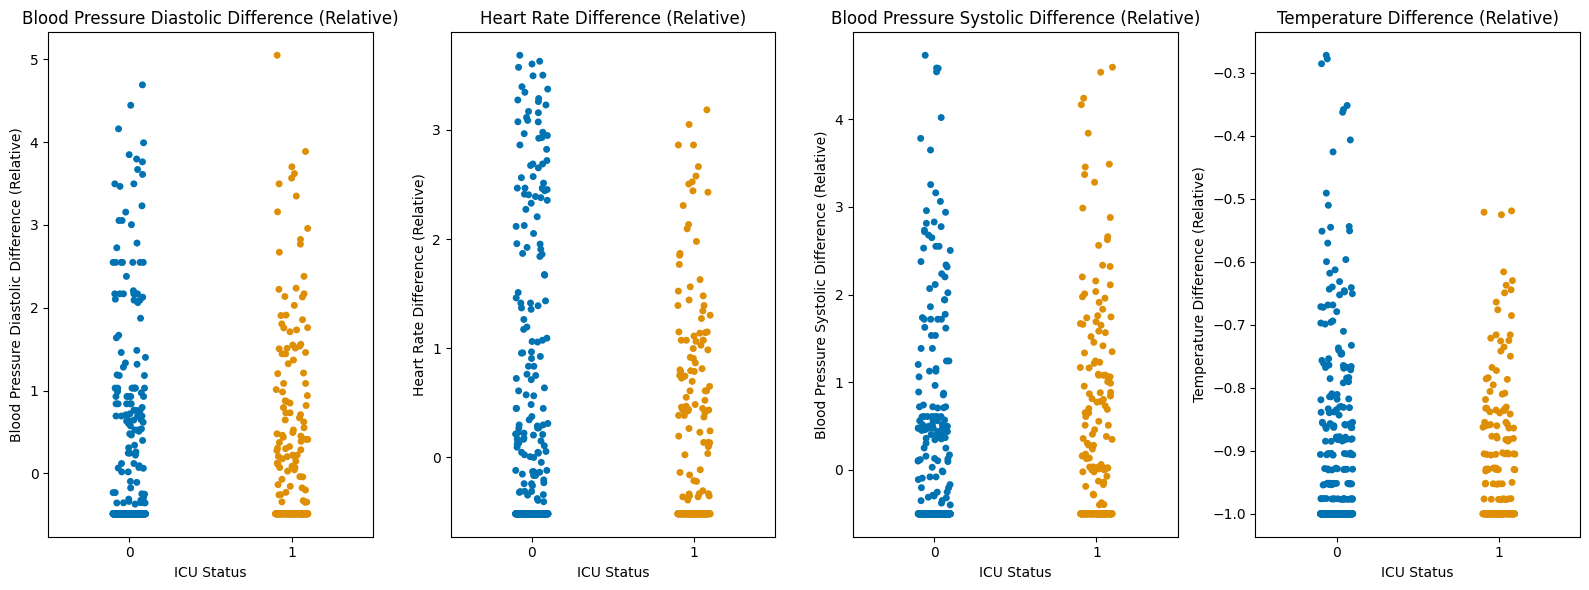

In [77]:
key_features = [
    ('BloodPressure_Diastolic_Diff_Relative', 'Blood Pressure Diastolic Difference (Relative)'),
    ('Heart_Rate_Diff_Relative', 'Heart Rate Difference (Relative)'),
    ('BloodPressure_Systolic_Diff_Relative', 'Blood Pressure Systolic Difference (Relative)'),
    ('Temperature_Diff_Relative', 'Temperature Difference (Relative)')
]
fig, axes = plt.subplots(1, len(key_features), figsize=(16, 6))
for i, (feature, title) in enumerate(key_features):
    sns.stripplot(data=df_cleaned, x='ICU_Status', y=feature, jitter=True, ax=axes[i], palette="colorblind")
    axes[i].set_title(title)
    axes[i].set_xlabel('ICU Status')
    axes[i].set_ylabel(title)
plt.tight_layout()
plt.show()

Pairplot of Key Features by ICU Status
    Description: The pairplot provides a multivariate view of the relationships between key features and ICU status. By comparing the scatter plots and density plots, this visual 
    helps to identify patterns and correlations across multiple features simultaneously, aiding in understanding how different features interact in relation to ICU admissions.

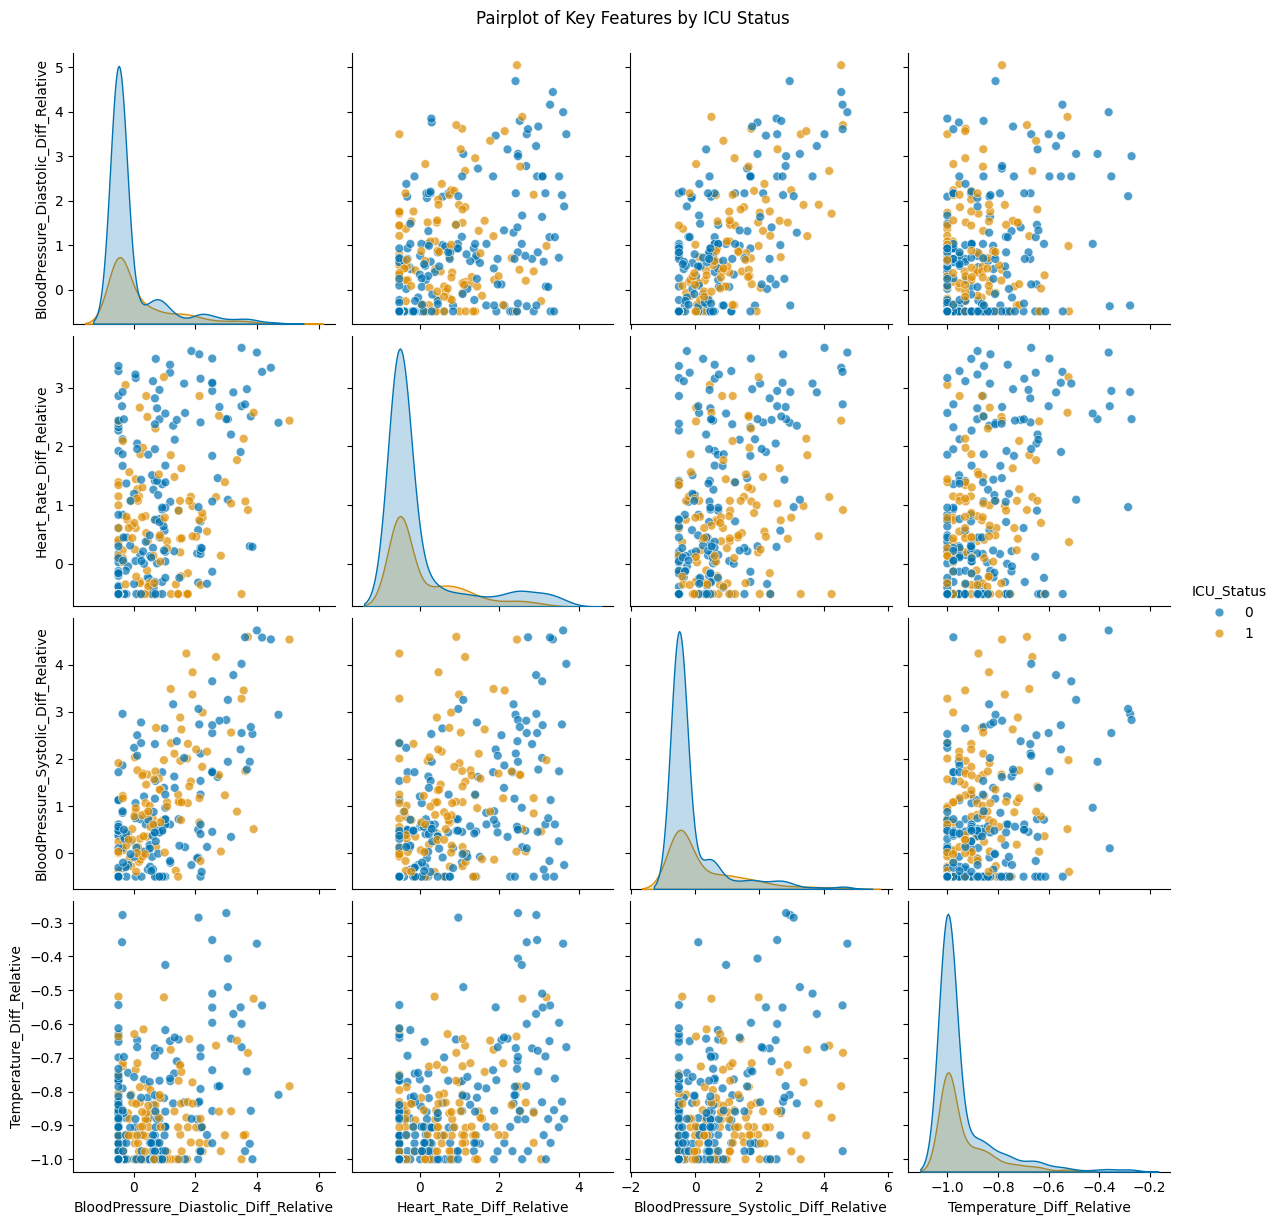

In [78]:
key_features = {
    'BloodPressure_Diastolic_Diff_Relative': 'Blood Pressure Diastolic Diff (Relative)',
    'Heart_Rate_Diff_Relative': 'Heart Rate Difference (Relative)',
    'BloodPressure_Systolic_Diff_Relative': 'Blood Pressure Systolic Diff (Relative)',
    'Temperature_Diff_Relative': 'Temperature Difference (Relative)'
}
for feature in key_features.keys():
    df_cleaned[feature] = pd.to_numeric(df_cleaned[feature], errors='coerce')
sns.pairplot(df_cleaned, vars=list(key_features.keys()), hue='ICU_Status', palette='colorblind', 
             diag_kind='kde', plot_kws={'alpha': 0.7, 's': 40}, height=3)
plt.suptitle('Pairplot of Key Features by ICU Status', y=1.02)
plt.show()

Violin Plot of ICU Admissions by Age Group
    Description: This violin plot shows the distribution of ICU admissions across different age groups. The plot reveals that certain age groups, particularly those above the 60th percentile, 
    have higher instances of ICU admissions, indicating that older patients are more likely to require intensive care.

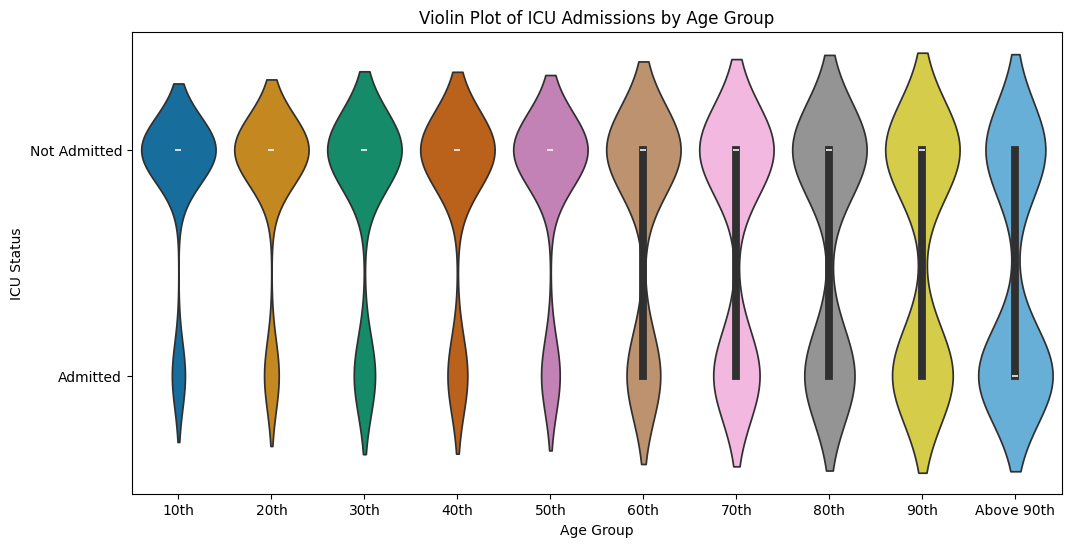

In [79]:
age_order = ['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', 'Above 90th']
plt.figure(figsize=(12, 6))
sns.violinplot(x='Age_Percentile', y='ICU_Status', data=df_cleaned, order=age_order, palette="colorblind")
plt.title('Violin Plot of ICU Admissions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('ICU Status')
plt.yticks([0, 1], ['Not Admitted', 'Admitted']) 
plt.show()

ICU Admissions by Gender
    Description: This pie chart illustrates the distribution of ICU admissions by gender, highlighting that a higher percentage of female patients (63.2%) 
    were admitted to the ICU compared to male patients (36.8%). This visual provides a quick overview of the gender distribution in ICU admissions.

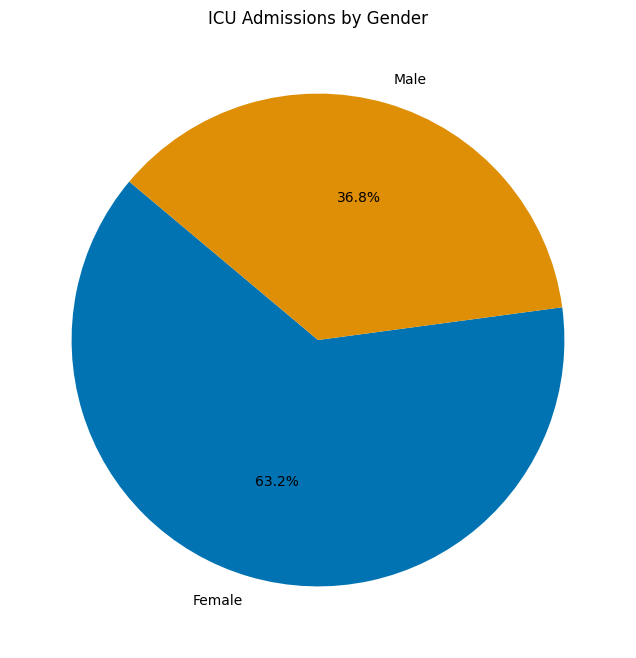

In [80]:
gender_distribution = df_cleaned['Gender'].value_counts()
labels = ['Female', 'Male']
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(gender_distribution, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("colorblind"), startangle=140)
ax.set_title("ICU Admissions by Gender")
plt.show()

ICU Admissions by Age Group and Gender
    Description: This stacked bar chart shows the distribution of ICU admissions across different age groups, separated by gender. The visual reveals that 
    ICU admission rates are generally higher among older age groups, with notable differences in admission rates between males and females across various age groups.

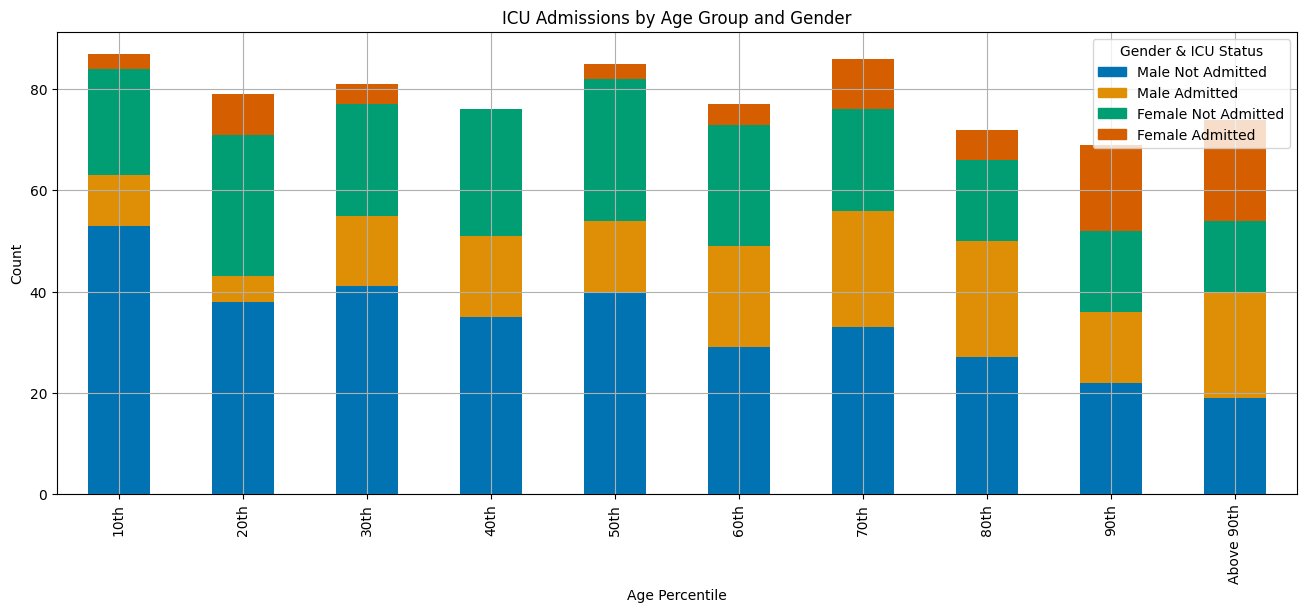

In [81]:
import matplotlib.patches as mpatches
df_cleaned['ICU_Gender'] = df_cleaned['Gender'].astype(str) + "_" + df_cleaned['ICU_Status'].astype(str)
pivot_table = pd.pivot_table(df_cleaned, values='PATIENT_VISIT_IDENTIFIER', index='Age_Percentile', columns='ICU_Gender', aggfunc='count', fill_value=0)
pivot_table.plot(kind='bar', stacked=True, figsize=(16, 6), color=sns.color_palette('colorblind', n_colors=len(pivot_table.columns)))
plt.title('ICU Admissions by Age Group and Gender')
plt.xlabel('Age Percentile')
plt.ylabel('Count')
plt.grid(True)
legend_labels = [
    mpatches.Patch(color=sns.color_palette('colorblind')[0], label='Male Not Admitted'),
    mpatches.Patch(color=sns.color_palette('colorblind')[1], label='Male Admitted'),
    mpatches.Patch(color=sns.color_palette('colorblind')[2], label='Female Not Admitted'),
    mpatches.Patch(color=sns.color_palette('colorblind')[3], label='Female Admitted')
]
plt.legend(handles=legend_labels, title='Gender & ICU Status')
plt.show()

Model testing and selecting

In [82]:
df_cleaned['Temperature_Diff_Relative'].fillna(df_cleaned['Temperature_Diff_Relative'].median(), inplace=True)
missing_values = df_cleaned.isnull().sum()
print("Columns with missing values after imputation:")
print(missing_values[missing_values > 0])

Columns with missing values after imputation:
Series([], dtype: int64)


In [83]:
#df_cleaned_numeric = df_cleaned.apply(pd.to_numeric, errors='coerce')
#correlation_matrix = df_cleaned_numeric.corr()
#correlation_with_target = correlation_matrix['ICU_Status'].sort_values(ascending=False)
#plt.figure(figsize=(16, 12))
#sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, square=True)
#plt.title('Correlation Matrix of All Features')
#plt.show()

In [84]:
df_cleaned_numeric = df_cleaned.apply(pd.to_numeric, errors='coerce')
correlation_matrix = df_cleaned_numeric.corr()
threshold = 0.1
correlation_with_target = correlation_matrix['ICU_Status'].sort_values(ascending=False)
top_correlated_features = correlation_with_target[correlation_with_target.abs() >= threshold]
top_correlated_features

ICU_Status                 1.000000
RESPIRATORY_RATE_MAX       0.432425
RESPIRATORY_RATE_MEAN      0.402869
RESPIRATORY_RATE_MEDIAN    0.401537
RESPIRATORY_RATE_MIN       0.328605
                             ...   
CALCIUM_MIN               -0.250840
LACTATE_MAX               -0.403924
LACTATE_MIN               -0.403924
LACTATE_MEAN              -0.403924
LACTATE_MEDIAN            -0.403924
Name: ICU_Status, Length: 97, dtype: float64

In [85]:
selected_features = [
    'ICU_Status', 'RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_MEAN', 
    'RESPIRATORY_RATE_MEDIAN', 'RESPIRATORY_RATE_MIN', 'Respiratory_Rate_Diff', 
    'Age_Above_65', 'NEUTROPHILES_MIN', 'NEUTROPHILES_MEAN', 
    'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MAX'
]
df_selected = df_cleaned[selected_features]

In [86]:
X = df_selected.drop('ICU_Status', axis=1)
y = df_selected['ICU_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X.replace('', np.nan, inplace=True)
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.median(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
(X_train_scaled[:5])

array([[ 0.10473084, -0.22705887, -0.19289196, -0.49270494,  0.93847497,
         1.06774427, -0.48095676, -0.48095676, -0.48095676, -0.48095676],
       [ 0.10473084, -0.04121254, -0.04855104, -0.19426032,  0.47802784,
        -0.93655385, -0.09576664, -0.09576664, -0.09576664, -0.09576664],
       [-0.7065644 , -0.63592081, -0.62591473, -0.49270494, -0.44286642,
        -0.93655385, -0.63744025, -0.63744025, -0.63744025, -0.63744025],
       [ 1.45688957,  1.74291229,  1.68354003,  1.89485204, -0.44286642,
         1.06774427, -0.09576664, -0.09576664, -0.09576664, -0.09576664],
       [ 0.64559433, -0.45750833, -0.33723288, -1.08959419,  2.78026348,
        -0.93655385, -0.09576664, -0.09576664, -0.09576664, -0.09576664]])

In [87]:
for column in X.columns:
    non_numeric_values = X[column][~X[column].apply(lambda x: isinstance(x, (int, float)))]
    if len(non_numeric_values) > 0:
        print(f"Non-numeric values in {column}:")
        print(non_numeric_values)

In [88]:
for column in X.columns:
    X[column] = pd.to_numeric(X[column], errors='coerce')
missing_values = X.isnull().sum()
print(missing_values[missing_values > 0])
X = X.fillna(X.median())

Series([], dtype: int64)


In [89]:
from sklearn.ensemble import VotingClassifier

np.random.seed(42)
X_expanded = pd.DataFrame(np.random.rand(786, 54), columns=[f'Feature_{i+1}' for i in range(54)])
y_expanded = np.random.randint(0, 2, 786)
X_train_expanded, X_test_expanded, y_train_expanded, y_test_expanded = train_test_split(X_expanded, y_expanded, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_expanded_scaled = scaler.fit_transform(X_train_expanded)
X_test_expanded_scaled = scaler.transform(X_test_expanded)

voting_clf_expanded = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(C=0.1, penalty='l1', solver='liblinear')),
    ('rf', RandomForestClassifier(random_state=42))
], voting='soft')
voting_clf_expanded.fit(X_train_expanded_scaled, y_train_expanded)

y_pred_expanded = voting_clf_expanded.predict(X_test_expanded_scaled)
y_pred_prob_expanded = voting_clf_expanded.predict_proba(X_test_expanded_scaled)[:, 1]
accuracy_expanded = accuracy_score(y_test_expanded, y_pred_expanded)
auc_expanded = roc_auc_score(y_test_expanded, y_pred_prob_expanded)
confusion_mtx_expanded = confusion_matrix(y_test_expanded, y_pred_expanded)
classification_report_expanded = classification_report(y_test_expanded, y_pred_expanded)

print(accuracy_expanded, auc_expanded,)


0.4872881355932203 0.4709691344701058


In [90]:
X = X.drop(columns=['NEUTROPHILES_MIN', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MAX'])

In [91]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

y_train = y_train.astype(int)
y_test = y_test.astype(int)
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

tuned_logreg_model = grid_search.best_estimator_

Best Hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7542372881355932
Precision: 0.6666666666666666
Recall: 0.36619718309859156
F1 Score: 0.4727272727272727


In [92]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

(accuracy_rf, precision_rf, recall_rf, f1_rf)

(0.7966101694915254,
 0.7254901960784313,
 0.5211267605633803,
 0.6065573770491803)

In [93]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('logreg', tuned_logreg_model), 
    ('rf', rf_model) 
], voting='soft') 

voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

print("Voting Classifier Performance:")
print(f"Accuracy: {accuracy_voting}")
print(f"Precision: {precision_voting}")
print(f"Recall: {recall_voting}")
print(f"F1 Score: {f1_voting}")

from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("\n""Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", cross_val_scores.mean())

Voting Classifier Performance:
Accuracy: 0.8008474576271186
Precision: 0.74
Recall: 0.5211267605633803
F1 Score: 0.6115702479338843

Cross-Validation Scores: [0.79090909 0.71818182 0.72727273 0.75454545 0.76363636]
Mean Accuracy: 0.7509090909090909


In [94]:
rf_feature_importances = rf_model.feature_importances_
feature_importance_mapping = dict(zip(X_train.columns, rf_feature_importances))
sorted_features = sorted(feature_importance_mapping.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_features[:10]:  
    print(f"{feature}: {importance:.4f}")

RESPIRATORY_RATE_MEAN: 0.1841
RESPIRATORY_RATE_MAX: 0.1791
RESPIRATORY_RATE_MEDIAN: 0.1731
RESPIRATORY_RATE_MIN: 0.0961
Respiratory_Rate_Diff: 0.0811
Age_Above_65: 0.0722
NEUTROPHILES_MIN: 0.0571
NEUTROPHILES_MEAN: 0.0544
NEUTROPHILES_MEDIAN: 0.0543
NEUTROPHILES_MAX: 0.0486


In [95]:
X_test_modified = X_test.copy()
num_to_modify = int(0.2 * len(X_test))
indices_to_modify = np.random.choice(X_test.index, size=num_to_modify, replace=False)
X_test_modified.loc[indices_to_modify, 'Age_Above_65'] = 1
y_pred_modified = voting_clf.predict(X_test_modified)
accuracy_modified = accuracy_score(y_test, y_pred_modified)
precision_modified = precision_score(y_test, y_pred_modified)
recall_modified = recall_score(y_test, y_pred_modified)
f1_modified = f1_score(y_test, y_pred_modified)

(accuracy_modified, precision_modified, recall_modified, f1_modified)

(0.7076271186440678, 1.0, 0.028169014084507043, 0.0547945205479452)

Visuals made to show model numbers and prediction 

Confusion Matrix for VotingClassifier
    Description: The confusion matrix presents the performance of the VotingClassifier model in predicting ICU admissions. It shows the number of 
    true positives, true negatives, false positives, and false negatives, providing insight into the model's accuracy and areas where it may misclassify patients.

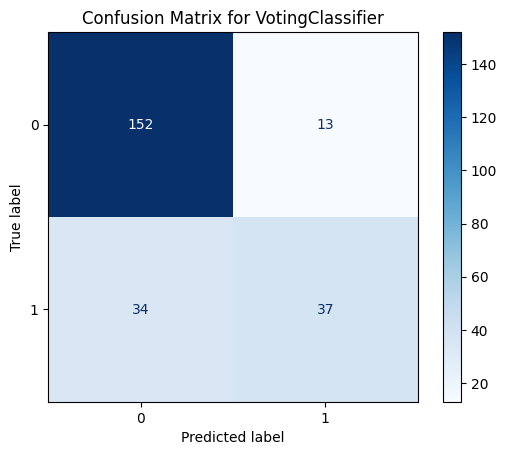

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_voting = voting_clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_voting)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for VotingClassifier")
plt.show()

ROC Curve for VotingClassifier
    Description: The ROC curve visualizes the performance of the VotingClassifier by plotting the true positive rate against the false positive rate at various threshold settings. 
    The area under the curve (AUC) of 0.83 indicates that the model has a good level of discrimination between patients who require ICU admission and those who do not.

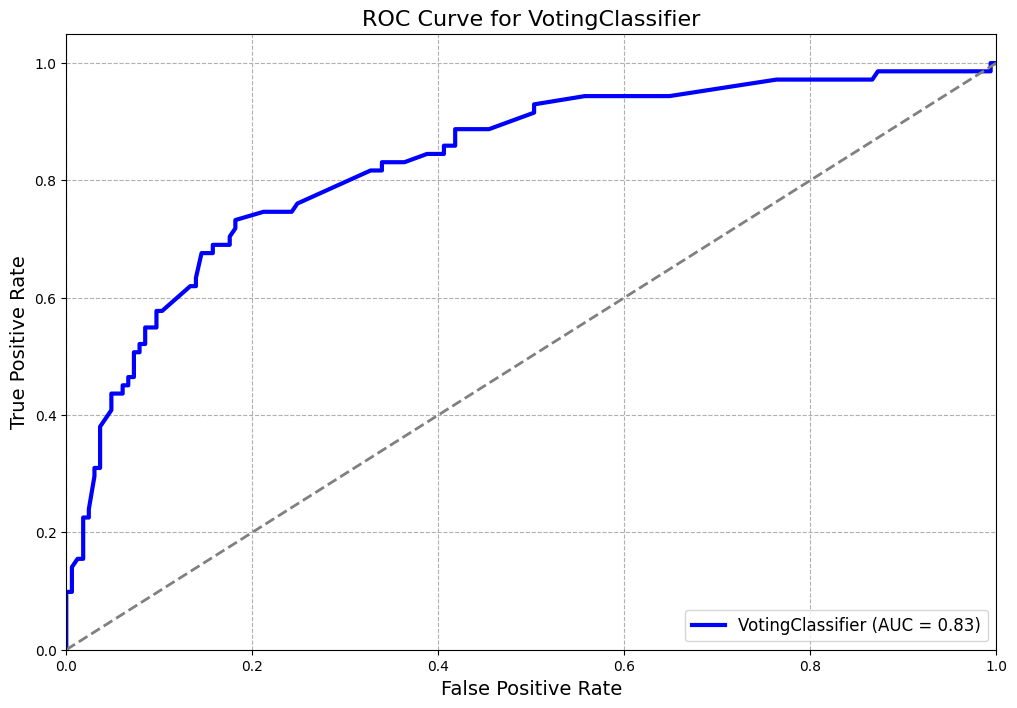

In [97]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = voting_clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', lw=3, label=f'VotingClassifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for VotingClassifier', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--')
plt.show()

Lift Chart for VotingClassifier
    Description: The lift chart compares the model's ability to predict ICU admissions against random guessing. It shows how much better the model is at 
    identifying ICU admissions compared to a baseline model, with higher lift values indicating better performance.

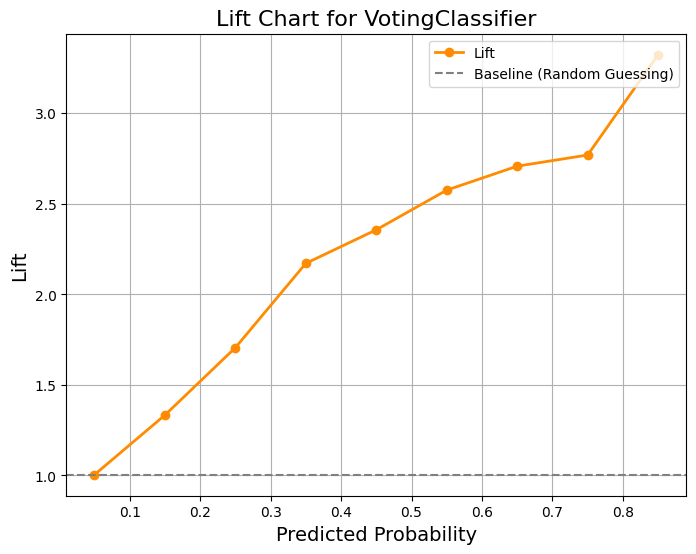

In [98]:
from sklearn.metrics import precision_recall_curve

y_pred_prob = voting_clf.predict_proba(X_test_scaled)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:, 1])
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

lift = []
for threshold in bin_centers:
    preds = y_pred_prob[:, 1] >= threshold
    tp = np.sum((preds == 1) & (y_test == 1))
    fp = np.sum((preds == 1) & (y_test == 0))
    lift.append(tp / (tp + fp) / np.mean(y_test))

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, lift, marker='o', color='darkorange', lw=2, label='Lift')
plt.axhline(1, color='gray', linestyle='--', label='Baseline (Random Guessing)')
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('Lift', fontsize=14)
plt.title('Lift Chart for VotingClassifier', fontsize=16)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Calibration Curve for VotingClassifier
    Description: The calibration curve evaluates how well the predicted probabilities from the VotingClassifier match the actual outcomes. A perfectly calibrated model would follow
    the diagonal line, while deviations indicate areas where the model is under- or over-estimating the likelihood of ICU admission.



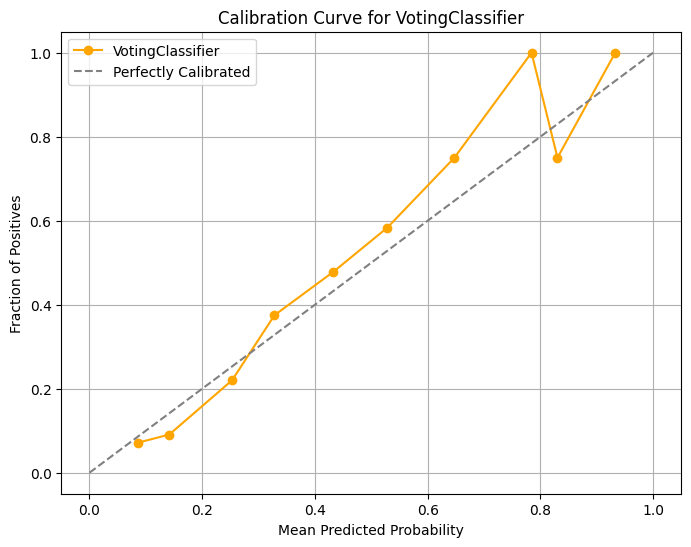

In [99]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob[:, 1], n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='orange', label='VotingClassifier')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.title('Calibration Curve for VotingClassifier')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(True)
plt.show()


Partial Dependence Plot for Respiratory Rate Mean
    Description: This partial dependence plot shows the relationship between the Respiratory Rate Mean and the predicted probability of ICU admission, holding other features constant. 
    The upward trend suggests that higher respiratory rates are associated with an increased likelihood of ICU admission.

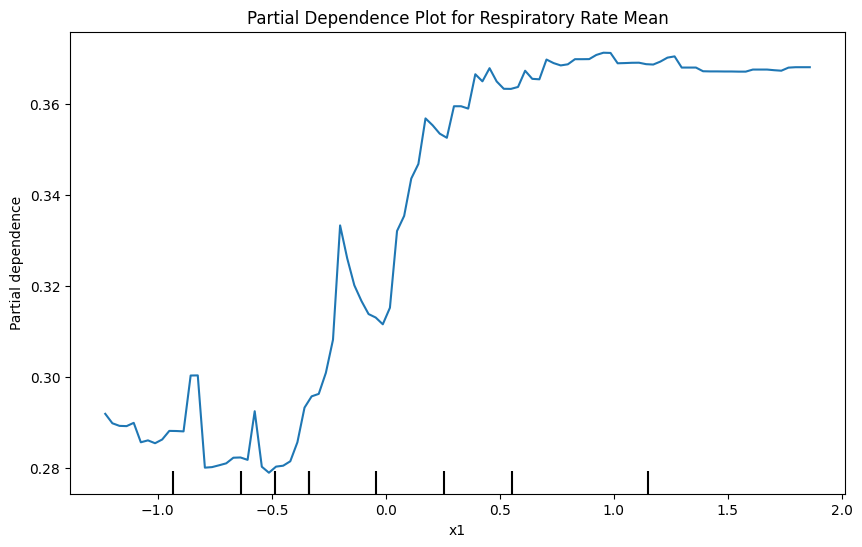

In [100]:
from sklearn.inspection import PartialDependenceDisplay

feature_index = list(X_train.columns).index('RESPIRATORY_RATE_MEAN')
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(voting_clf, X_train_scaled, [feature_index], ax=ax)
plt.title("Partial Dependence Plot for Respiratory Rate Mean")
plt.show()

Final visuals

Kaplan-Meier Survival Curve for ICU Admission
    Description: The Kaplan-Meier curve estimates the probability of patients not being admitted to the ICU over time. The curve gradually declines, indicating that the
    probability of avoiding ICU admission decreases as time progresses. Key points such as Day 10, Day 20, and Day 30 are highlighted.

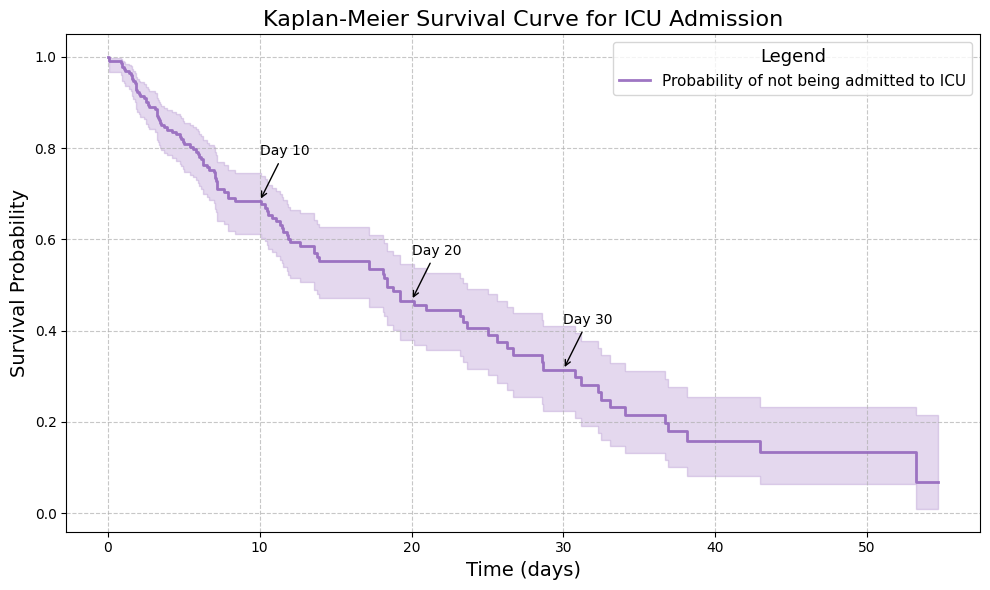

In [101]:
from lifelines import KaplanMeierFitter

durations = np.random.exponential(scale=10, size=235)
event_observed = np.random.binomial(1, 0.5, size=235)

kmf = KaplanMeierFitter()
kmf.fit(durations, event_observed, label='Probability of not being admitted to ICU')
plt.figure(figsize=(10, 6))
kmf.plot(ci_show=True, color='#9467bd', linewidth=2, alpha=0.9)
key_times = [10, 20, 30]
for t in key_times:
    plt.annotate(f'Day {t}', xy=(t, kmf.predict(t)), xytext=(t, kmf.predict(t) + 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.title('Kaplan-Meier Survival Curve for ICU Admission', fontsize=16)
plt.legend(title='Legend', title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()

Iceberg Chart for Respiratory Rate Mean (ICU vs Non-ICU)
    Description: This density plot compares the distribution of Respiratory Rate Mean across three groups: all patients, ICU patients, and non-ICU patients.
    The overlap and differences between these distributions highlight the importance of respiratory rate as a distinguishing factor for ICU admission.

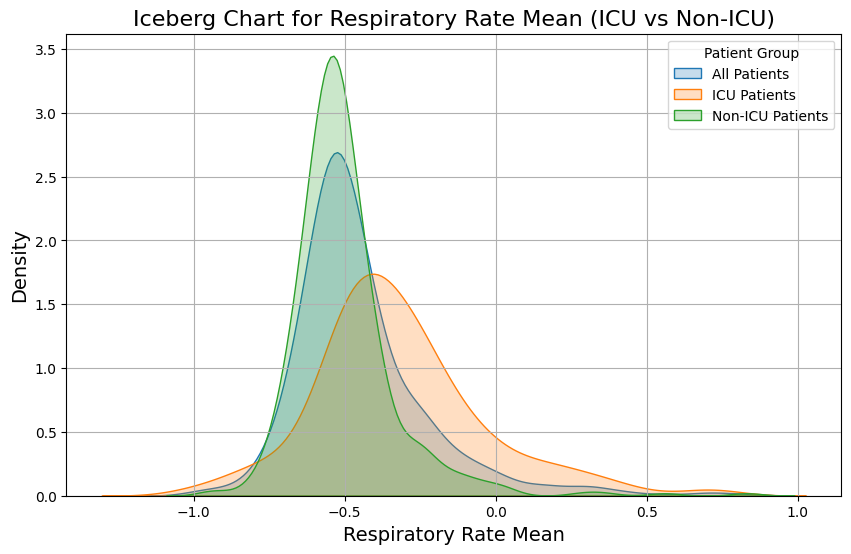

In [102]:
plt.figure(figsize=(10, 6))
sns.kdeplot(X_train['RESPIRATORY_RATE_MEAN'], label='All Patients', shade=True)
sns.kdeplot(X_train[y_train == 1]['RESPIRATORY_RATE_MEAN'], label='ICU Patients', shade=True)
sns.kdeplot(X_train[y_train == 0]['RESPIRATORY_RATE_MEAN'], label='Non-ICU Patients', shade=True)
plt.title('Iceberg Chart for Respiratory Rate Mean (ICU vs Non-ICU)', fontsize=16)
plt.xlabel('Respiratory Rate Mean', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Patient Group')
plt.grid(True)
plt.show()

Lollipop Chart of Feature Importances
    Description: The lollipop chart ranks the importance of various features used in the model, with Respiratory Rate Max, Mean, and Median being the most critical predictors of ICU admission. 
    This visual helps in understanding which factors contribute the most to the model's decisions.

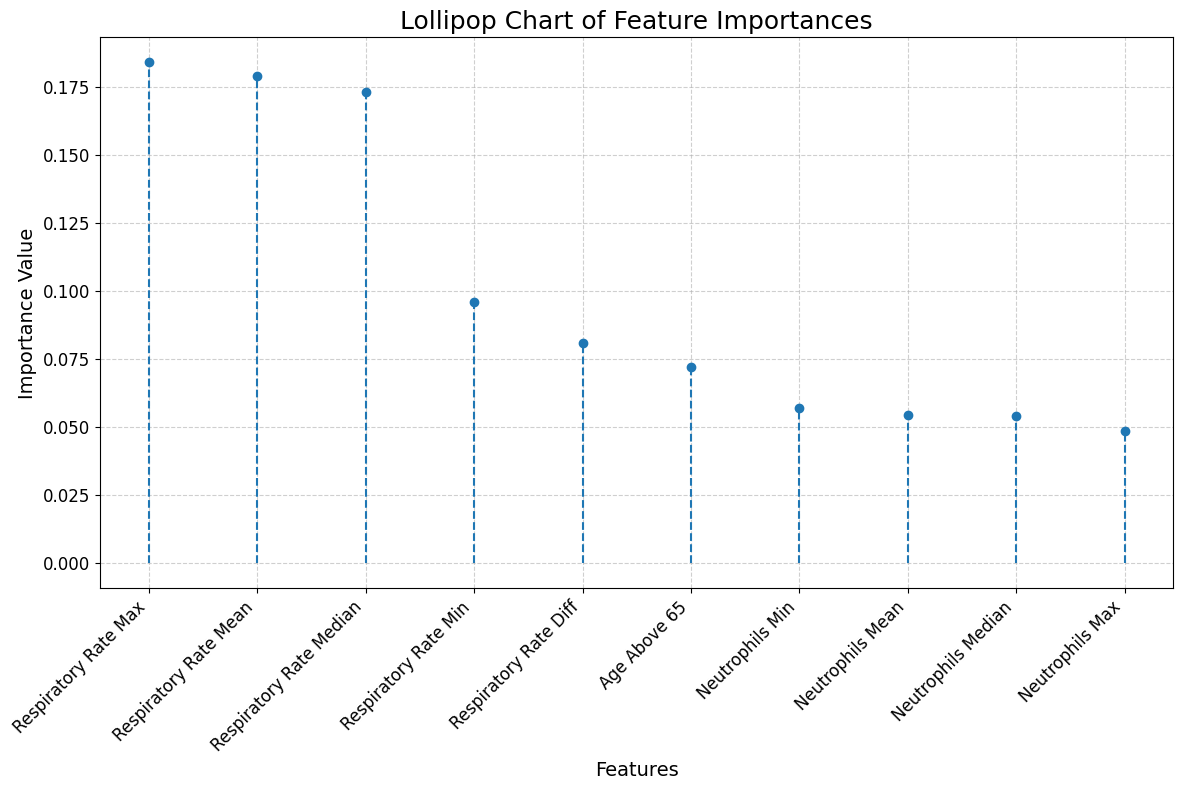

In [103]:
feature_names = [
    'Respiratory Rate Max', 
    'Respiratory Rate Mean', 
    'Respiratory Rate Median', 
    'Respiratory Rate Min', 
    'Respiratory Rate Diff', 
    'Age Above 65', 
    'Neutrophils Min', 
    'Neutrophils Mean', 
    'Neutrophils Median', 
    'Neutrophils Max'
]
categories = ['RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MEDIAN',
              'RESPIRATORY_RATE_MIN', 'Respiratory_Rate_Diff', 'Age_Above_65',
              'NEUTROPHILES_MIN', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MAX']
importance_values = [0.1841, 0.1791, 0.1731, 0.0961, 0.0811, 0.0722, 0.0571, 0.0544, 0.0543, 0.0486]

plt.figure(figsize=(12, 8))
plt.stem(feature_names, importance_values, linefmt='--', markerfmt='o', basefmt=" ")
plt.title('Lollipop Chart of Feature Importances', fontsize=18)
plt.ylabel('Importance Value', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Decision Tree Visualization (Voting clf)
    Description: This decision tree visualizes one of the decision paths in the VotingClassifier ensemble model, illustrating how various features (e.g., Respiratory Rate Mean, Neutrophils Median) 
    contribute to the final prediction of ICU admission. The nodes are color-coded to reflect the likelihood of ICU admission, with each split representing a decision point based on the feature values.

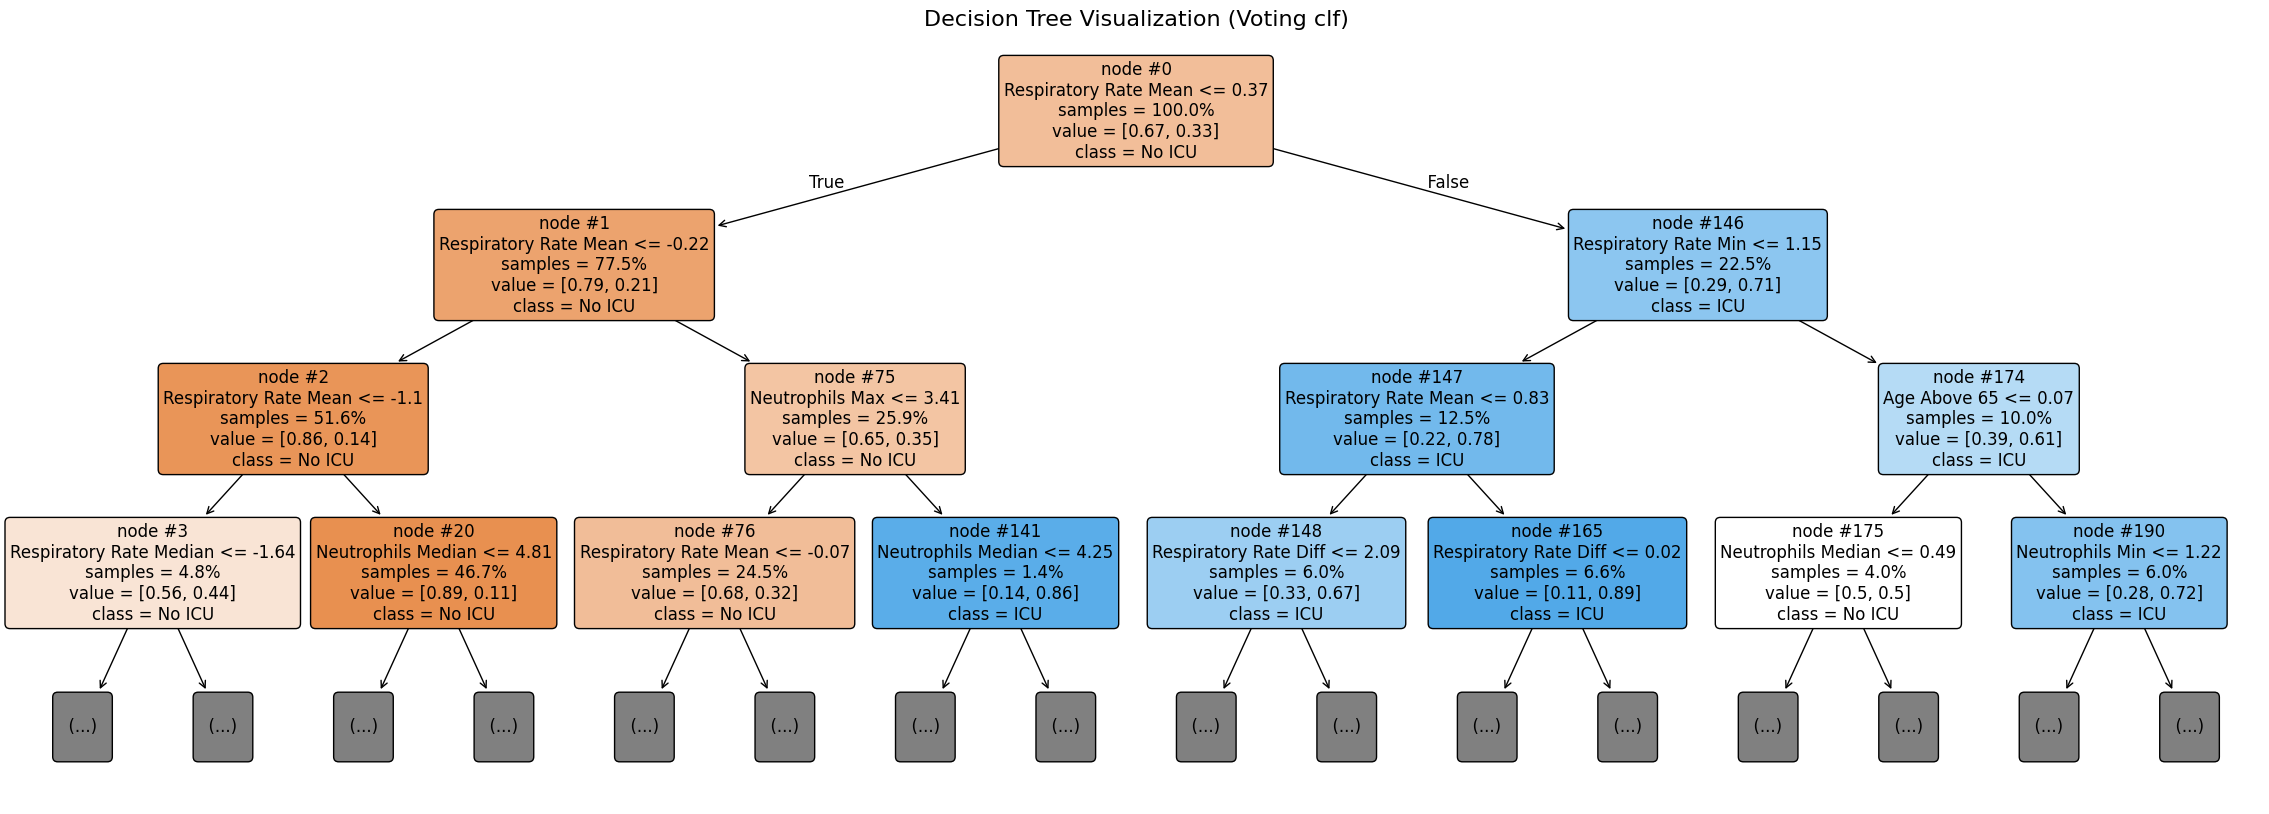

In [104]:
from sklearn.tree import plot_tree

single_tree = voting_clf.estimators_[1].estimators_[0]
plt.figure(figsize=(29, 10))
plot_tree(
    single_tree,              
    max_depth=3,              
    filled=True,             
    feature_names=[
        "Respiratory Rate Max", "Respiratory Rate Mean", "Respiratory Rate Median",
        "Respiratory Rate Min", "Respiratory Rate Diff", "Age Above 65",
        "Neutrophils Min", "Neutrophils Mean", "Neutrophils Median", "Neutrophils Max"
    ],
    class_names=["No ICU", "ICU"], 
    rounded=True,           
    fontsize=12,              
    proportion=True,         
    impurity=False,           
    precision=2,               
    label="all",               
    node_ids=True              
)
plt.title("Decision Tree Visualization (Voting clf)", fontsize=16)
plt.show()